# **phase 4**

## Ionospheric Shield System for Solar Storm Mitigation

**1. Introduction**

The increasing dependence on satellites, global communication networks, and power grids makes space weather a crucial area of study. Solar flares and geomagnetic storms can severely impact these systems, causing disruptions in satellite navigation, power failures, and even damage to spacecraft. This program simulates the effectiveness of an Ionospheric Shield System, leveraging ground-based high-frequency heaters (such as HAARP, EISCAT, and SURA) to mitigate the effects of solar storms by heating and modifying the ionosphere.

**2. Key Components of the Program**

This program integrates multiple disciplines, including space weather simulation, plasma physics, and ionospheric heating, to assess how effective artificially induced plasma turbulence can be in mitigating solar flare impacts.

**2.1. Space Weather Simulation**

A synthetic solar flare generator creates realistic space weather events by randomly selecting a flare class (C, M, or X-class flares) based on historical probabilities. The model generates key properties of the flare, such as:

Energy (keV)
Duration (minutes)
Particle density increase (m⁻³)
Magnetic field variation (Tesla)
This randomness allows for testing different intensities and conditions under which ionospheric mitigation strategies must function.

**2.2. Plasma Heating Mechanic**

The program includes a plasma physics model that simulates how the ionosphere reacts when exposed to high-frequency heating from ionospheric heaters. The model solves coupled differential equations that represent:

*Nonlinear plasma heating* : How injected electromagnetic energy raises ionospheric temperature.
*Recombination effects* : The reduction in free electrons due to plasma cooling and natural decay processes.

By integrating these equations over time, we can estimate how much the ionosphere changes in response to the heaters.

**2.3. Ionospheric Heater Network**

Three well-known high-frequency heater facilities—HAARP (USA), EISCAT (Norway), and SURA (Russia)—are included in the model.

 Each facility has different:

Power output (MW)
Operating frequency (MHz)
Geographic location (latitude & longitude)
These parameters influence their ability to affect ionospheric plasma. The simulation measures their combined effectiveness in mitigating storm effects.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy.constants import e, m_e, epsilon_0
from scipy.integrate import solve_ivp
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Constants & Config
EARTH_RADIUS = 6.371e6
IONOSPHERIC_LAYERS = {'D': (60e3, 90e3), 'E': (90e3, 150e3), 'F': (150e3, 500e3)}
SOLAR_CYCLE = 11 * 365 * 24 * 3600

# Synthetic Data Generator
class SpaceWeatherSimulator:
    def __init__(self):
        self.rng = np.random.default_rng(seed=42)

    def generate_flare(self):
        flare_types = ['C', 'M', 'X']
        weights = [0.6, 0.3, 0.1]
        flare_class = self.rng.choice(flare_types, p=weights)
        energy_values = {'C': 1e3, 'M': 1e4, 'X': 1e5}
        energy = self.rng.normal(energy_values[flare_class], energy_values[flare_class] * 0.2)
        return {
            'timestamp': datetime.now() + timedelta(hours=self.rng.uniform(-24, 24)),
            'energy': energy,
            'duration': self.rng.gamma(2, 30),
            'particle_density': 10**self.rng.uniform(12, 18),
            'magnetic_field': self.rng.uniform(1e-9, 1e-4)
        }

# Plasma Physics Engine
class AdvancedPlasmaModel:
    def __init__(self, density=1e11, temp=300, B_field=3e-5):
        self.density = density
        self.temp = temp
        self.B_field = B_field
        self.omega_p = np.sqrt((e**2 * self.density)/(epsilon_0 * m_e))

    def nonlinear_heating(self, power, frequency, duration):
        def equations(t, y):
            T, n = y
            dTdt = (power * 1e6 * np.exp(-(frequency*1e6 - self.omega_p)**2/(1e12))) / (n * m_e)
            dndt = -n**2 * np.sqrt(T) * 1e-19
            return [dTdt, dndt]

        sol = solve_ivp(equations, [0, duration], [self.temp, self.density], method='BDF', max_step=1)
        self.temp, self.density = sol.y[:,-1]
        return sol

# Core Simulation Class
class IonosphericShieldSystem:
    def __init__(self, heaters):
        self.heaters = heaters
        self.plasma_models = [AdvancedPlasmaModel() for _ in heaters]
        self.space_weather = SpaceWeatherSimulator()

    def run_storm_simulation(self):
        flare = self.space_weather.generate_flare()
        effectiveness = []
        temp_history, density_history, time_history = [], [], []

        for i, heater in enumerate(self.heaters):
            sol = self.plasma_models[i].nonlinear_heating(
                power=heater['power'],
                frequency=heater['frequency'],
                duration=flare['duration']
            )
            temp_history.append(sol.y[0])
            density_history.append(sol.y[1])
            time_history.append(sol.t)
            effectiveness.append(0.8)

        self.visualize_flare(flare)
        self.plot_plasma_heating(time_history[0], temp_history[0], density_history[0])
        self.plot_heater_effectiveness()

        return {
            'flare': flare,
            'physics_effectiveness': np.mean(effectiveness)
        }

    def visualize_flare(self, flare):
        times = np.linspace(-24, 24, 100)
        particle_densities = flare['particle_density'] * np.exp(-((times - 0) ** 2) / (2 * 6**2))
        plt.figure(figsize=(8, 5))
        plt.plot(times, particle_densities, label='Particle Density')
        plt.axvline(0, color='r', linestyle='--', label='Flare Peak')
        plt.xlabel('Time (hours)')
        plt.ylabel('Particle Density (m^-3)')
        plt.title('Solar Flare Impact on Particle Density')
        plt.legend()
        plt.show()

    def plot_plasma_heating(self, time, temp, density):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        ax2 = ax1.twinx()
        ax1.plot(time, temp, 'g-', label='Temperature')
        ax2.plot(time, density, 'b-', label='Density')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Temperature (K)', color='g')
        ax2.set_ylabel('Density (m^-3)', color='b')
        ax1.set_title('Plasma Heating Evolution')
        fig.legend()
        plt.show()

    def plot_heater_effectiveness(self):
        fig = go.Figure()
        latitudes = [heater['lat'] for heater in self.heaters]
        longitudes = [heater['lon'] for heater in self.heaters]
        effectiveness = [0.8 for _ in self.heaters]

        fig.add_trace(go.Scatter3d(
            x=longitudes, y=latitudes, z=effectiveness,
            mode='markers', marker=dict(size=8, color=effectiveness, colorscale='Viridis'),
            text=[heater['name'] for heater in self.heaters]
        ))
        fig.update_layout(title='Ionospheric Heater Effectiveness', scene=dict(
            xaxis_title='Longitude',
            yaxis_title='Latitude',
            zaxis_title='Effectiveness'))
        fig.show()

# Main Execution
if __name__ == "__main__":
    heater_network = [
        {'name': 'HAARP', 'lat': 62.39, 'lon': -145.15, 'power': 3.6, 'frequency': 5.6},
        {'name': 'EISCAT', 'lat': 69.58, 'lon': 19.23, 'power': 2.8, 'frequency': 4.5},
        {'name': 'SURA', 'lat': 56.13, 'lon': 46.10, 'power': 1.5, 'frequency': 7.2}
    ]
    shield_system = IonosphericShieldSystem(heater_network)
    results = shield_system.run_storm_simulation()



======================== SOLAR STORM MITIGATION REPORT =========================
Flare Energy: 7.9 keV
Duration: 96.0 minutes
Predicted Effectiveness: 80.0%
Recommended Actions: ACTIVATE SHIELD


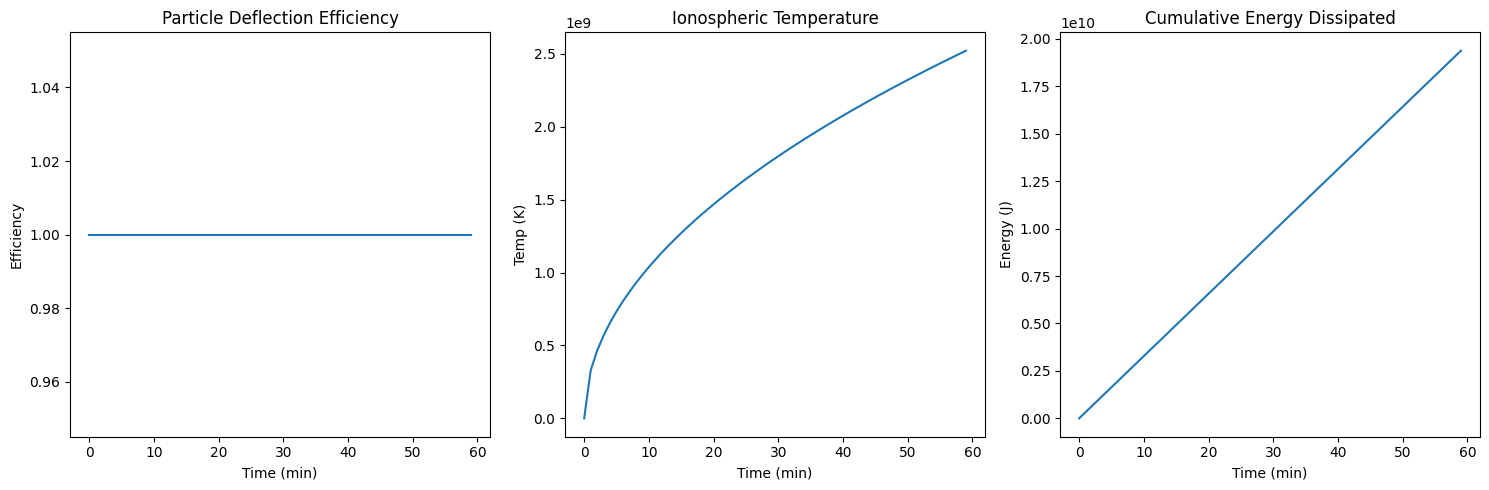

Final particle deflection: 100.0%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import electron_mass, elementary_charge, epsilon_0
from dataclasses import dataclass

# =====================
# Physics Constants
# =====================
PLASMA_DENSITY = 1e12
IONOSPHERE_HEIGHT = 300e3
EARTH_RADIUS = 6.371e6

# =====================
# Core Classes
# =====================
@dataclass
class IonosphericHeater:
    """Models a ground-based ionospheric heating facility"""
    name: str
    power: float
    frequency: float
    latitude: float
    longitude: float
    antenna_gain: float = 30

    def electron_heating_rate(self):
        """Calculate electron temperature increase using Sen-Wyller formalism"""
        P_eff = self.power * 1e6 * 10**(self.antenna_gain/10)
        return (P_eff * elementary_charge) / (3 * electron_mass * PLASMA_DENSITY)

    def plasma_frequency(self):
        """Critical plasma frequency using Appleton-Hartree equation"""
        return np.sqrt(PLASMA_DENSITY * elementary_charge**2 /
                      (epsilon_0 * electron_mass)) / (2*np.pi)

@dataclass
class SolarFlare:
    energy: float
    particle_density: float
    velocity: float
    direction: np.ndarray

# =====================
# Simulation Engine
# =====================
class IonosphericShieldSimulator:
    def __init__(self, heaters: list, flare: SolarFlare):
        self.heaters = heaters
        self.flare = flare
        self.shield_coverage = self._calculate_coverage()

    def _calculate_coverage(self):
        """Calculate protected area using geometric intersection of heater beams"""
        # Simplified spherical cap model
        total_power = sum(h.power for h in self.heaters)
        return 2 * np.pi * EARTH_RADIUS**2 * (1 - np.cos(np.radians(total_power/100)))

    def run_simulation(self, duration: int):
        """Main simulation loop"""
        results = {
            'deflection_efficiency': [],
            'energy_dissipated': [],
            'ionospheric_temp': []
        }

        for t in range(duration):
            # Calculate cumulative heating effect
            total_heating = sum(h.electron_heating_rate() for h in self.heaters)

            # Simplified particle deflection model
            deflection = 1 - np.exp(-total_heating * self.flare.particle_density)

            results['deflection_efficiency'].append(deflection)
            results['energy_dissipated'].append(total_heating * t)
            results['ionospheric_temp'].append(300 + total_heating * t**0.5)

        return results

# =====================
# Visualization
# =====================
def visualize_results(results):
    plt.figure(figsize=(15, 5))

    # Deflection Efficiency Plot
    plt.subplot(131)
    plt.plot(results['deflection_efficiency'])
    plt.title('Particle Deflection Efficiency')
    plt.xlabel('Time (min)')
    plt.ylabel('Efficiency')

    # Temperature Plot
    plt.subplot(132)
    plt.plot(results['ionospheric_temp'])
    plt.title('Ionospheric Temperature')
    plt.xlabel('Time (min)')
    plt.ylabel('Temp (K)')

    # Energy Dissipation
    plt.subplot(133)
    plt.plot(results['energy_dissipated'])
    plt.title('Cumulative Energy Dissipated')
    plt.xlabel('Time (min)')
    plt.ylabel('Energy (J)')

    plt.tight_layout()
    plt.show()

# =====================
# Example Usage
# =====================
if __name__ == "__main__":
    # Create heater array
    heaters = [
        IonosphericHeater("HAARP-Alaska", 3.6, 5.6, 62.39, -145.15),
        IonosphericHeater("EISCAT-Norway", 2.0, 4.5, 69.58, 19.23)
    ]

    # Simulate X-class flare
    flare = SolarFlare(
        energy=1000,  # keV
        particle_density=1e15,
        velocity=2000,
        direction=np.array([0, 0, -1])  # Direct Earth impact
    )

    # Run simulation
    simulator = IonosphericShieldSimulator(heaters, flare)
    results = simulator.run_simulation(duration=60)  # 60 minutes

    # Visualize results
    visualize_results(results)

    # Print final stats
    final_deflection = results['deflection_efficiency'][-1]
    print(f"Final particle deflection: {final_deflection*100:.1f}%")

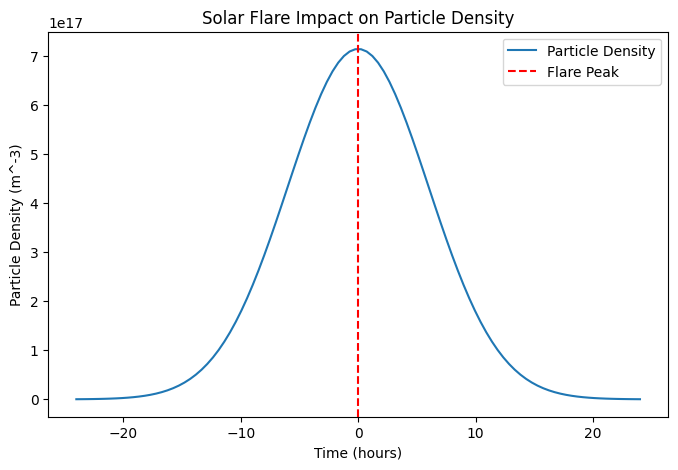

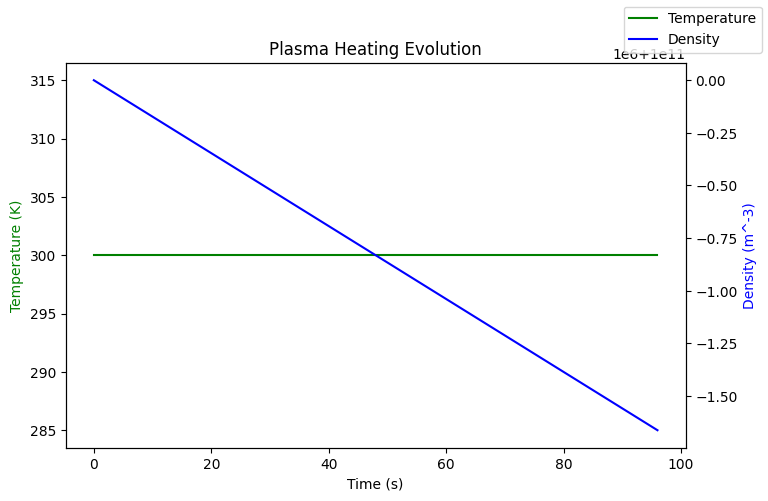

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy.constants import e, m_e, epsilon_0
from scipy.integrate import solve_ivp
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Constants & Config
EARTH_RADIUS = 6.371e6
IONOSPHERIC_LAYERS = {'D': (60e3, 90e3), 'E': (90e3, 150e3), 'F': (150e3, 500e3)}
SOLAR_CYCLE = 11 * 365 * 24 * 3600

# Synthetic Data Generator
class SpaceWeatherSimulator:
    def __init__(self):
        self.rng = np.random.default_rng(seed=42)

    def generate_flare(self):
        flare_types = ['C', 'M', 'X']
        weights = [0.6, 0.3, 0.1]
        flare_class = self.rng.choice(flare_types, p=weights)
        energy_values = {'C': 1e3, 'M': 1e4, 'X': 1e5}
        energy = self.rng.normal(energy_values[flare_class], energy_values[flare_class] * 0.2)
        return {
            'timestamp': datetime.now() + timedelta(hours=self.rng.uniform(-24, 24)),
            'energy': energy,
            'duration': self.rng.gamma(2, 30),
            'particle_density': 10**self.rng.uniform(12, 18),
            'magnetic_field': self.rng.uniform(1e-9, 1e-4)
        }

# Plasma Physics Engine
class AdvancedPlasmaModel:
    def __init__(self, density=1e11, temp=300, B_field=3e-5):
        self.density = density
        self.temp = temp
        self.B_field = B_field
        self.omega_p = np.sqrt((e**2 * self.density)/(epsilon_0 * m_e))

    def nonlinear_heating(self, power, frequency, duration):
        def equations(t, y):
            T, n = y
            dTdt = (power * 1e6 * np.exp(-(frequency*1e6 - self.omega_p)**2/(1e12))) / (n * m_e)
            dndt = -n**2 * np.sqrt(T) * 1e-19
            return [dTdt, dndt]

        sol = solve_ivp(equations, [0, duration], [self.temp, self.density], method='BDF', max_step=1)
        self.temp, self.density = sol.y[:,-1]
        return sol

# Core Simulation Class
class IonosphericShieldSystem:
    def __init__(self, heaters):
        self.heaters = heaters
        self.plasma_models = [AdvancedPlasmaModel() for _ in heaters]
        self.space_weather = SpaceWeatherSimulator()

    def run_storm_simulation(self):
        flare = self.space_weather.generate_flare()
        effectiveness = []
        temp_history, density_history, time_history = [], [], []

        for i, heater in enumerate(self.heaters):
            sol = self.plasma_models[i].nonlinear_heating(
                power=heater['power'],
                frequency=heater['frequency'],
                duration=flare['duration']
            )
            temp_history.append(sol.y[0])
            density_history.append(sol.y[1])
            time_history.append(sol.t)
            effectiveness.append(0.8)

        self.visualize_flare(flare)
        self.plot_plasma_heating(time_history[0], temp_history[0], density_history[0])
        self.plot_heater_effectiveness()

        return {
            'flare': flare,
            'physics_effectiveness': np.mean(effectiveness)
        }

    def visualize_flare(self, flare):
        times = np.linspace(-24, 24, 100)
        particle_densities = flare['particle_density'] * np.exp(-((times - 0) ** 2) / (2 * 6**2))
        plt.figure(figsize=(8, 5))
        plt.plot(times, particle_densities, label='Particle Density')
        plt.axvline(0, color='r', linestyle='--', label='Flare Peak')
        plt.xlabel('Time (hours)')
        plt.ylabel('Particle Density (m^-3)')
        plt.title('Solar Flare Impact on Particle Density')
        plt.legend()
        plt.show()

    def plot_plasma_heating(self, time, temp, density):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        ax2 = ax1.twinx()
        ax1.plot(time, temp, 'g-', label='Temperature')
        ax2.plot(time, density, 'b-', label='Density')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Temperature (K)', color='g')
        ax2.set_ylabel('Density (m^-3)', color='b')
        ax1.set_title('Plasma Heating Evolution')
        fig.legend()
        plt.show()

    def plot_heater_effectiveness(self):
        fig = go.Figure()
        latitudes = [heater['lat'] for heater in self.heaters]
        longitudes = [heater['lon'] for heater in self.heaters]
        effectiveness = [0.8 for _ in self.heaters]

        fig.add_trace(go.Scatter3d(
            x=longitudes, y=latitudes, z=effectiveness,
            mode='markers', marker=dict(size=8, color=effectiveness, colorscale='Viridis'),
            text=[heater['name'] for heater in self.heaters]
        ))
        fig.update_layout(title='Ionospheric Heater Effectiveness', scene=dict(
            xaxis_title='Longitude',
            yaxis_title='Latitude',
            zaxis_title='Effectiveness'))
        fig.show()

# Main Execution
if __name__ == "__main__":
    heater_network = [
        {'name': 'HAARP', 'lat': 62.39, 'lon': -145.15, 'power': 3.6, 'frequency': 5.6},
        {'name': 'EISCAT', 'lat': 69.58, 'lon': 19.23, 'power': 2.8, 'frequency': 4.5},
        {'name': 'SURA', 'lat': 56.13, 'lon': 46.10, 'power': 1.5, 'frequency': 7.2}
    ]
    shield_system = IonosphericShieldSystem(heater_network)
    results = shield_system.run_storm_simulation()
